In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax
####################################### Plotting Function
def set_label(ax, xpcent, ypcent, text, fontsize=12, color='k'):
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x2 = xpcent/100.
    x1 = 1.-x2
    y2 = ypcent/100.
    y1 = 1.-y2
    x0 = x1*Xlm[0]+x2*Xlm[1]
    y0 = y1*Ylm[0]+y2*Ylm[1]
    ax.text(x0,y0, text, fontsize=fontsize, color=color)



In [3]:
########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768]

W1_maglim = I_maglim

In [4]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

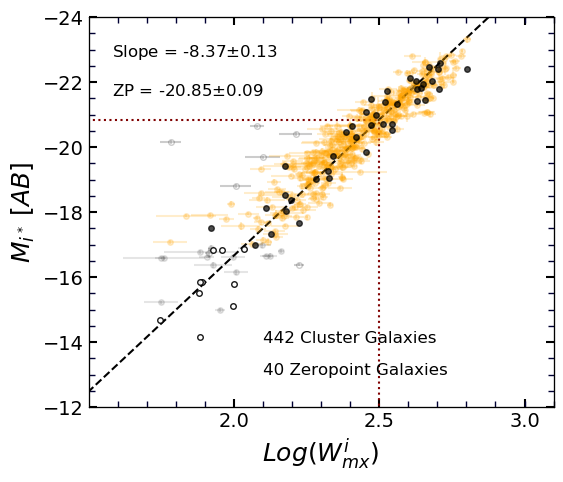

In [5]:
band='i'
fig, ax, Clusters, S_ZP = makeTF(table, pgcFaint=W1_maglim, calib_maglim=calib_maglim, band=band, makePlot=True)

In [6]:
slope = S_ZP[0]
zp    = S_ZP[2]

zp_calibs = all_ZP(table, band=band, slope=slope, pgcFaint=calib_maglim)

MAGdict = {}
for key0 in Clusters:
#     key0 = 'NEST_100008'
    myCluster = Clusters[key0]
    zp_virgo  = myCluster['zp']

    MAG       = myCluster['mag']-zp_virgo+zp
    MAG_w     = myCluster['mag_w']-zp_virgo+zp
    logWimx   = myCluster['logWimx']
    logWimx_w = myCluster['logWimx_w']
    pgc       = myCluster['pgc']
    pgc_w     = myCluster['pgc_w']


    indx = []
    indx_ = []    
    for i, id in enumerate(pgc):
        if not id in W1_maglim:
            indx.append(i)
        else:
            indx_.append(i) # faint


    MAG_faint       = []
    logWimx_faint   = []
    pgc_faint       = []

    if len(indx_)>0:
        MAG_faint       = MAG[indx_]
        logWimx_faint   = logWimx[indx_]
        pgc_faint       = pgc[indx_]

    if len(indx)>0:
        MAG       = MAG[indx]
        logWimx   = logWimx[indx]
        pgc       = pgc[indx]
    
    d_modulus = zp_virgo-zp
    dist = 10**((d_modulus-25.)/5.)
    MAGdict[key0] = [MAG,  d_modulus, dist]
    

In [7]:
d_lst = []
keys = []
for key in MAGdict:
    d_lst.append(MAGdict[key][2])
    keys.append(key)
indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, Clusters[key]['name'], '--> %d'%MAGdict[key][2], MAGdict[key][1]

NEST_200015 Fornax --> 0 20.847503259924686
NEST_200017 Abell 539 --> 0 20.847503259924686
NEST_100006 Hydra --> 0 20.847503259924686
NEST_100003 Centaurus --> 0 20.847503259924686
NEST_100014 Antlia --> 0 20.847503259924686
NEST_100002 Virgo --> 14 30.862481686093215
NEST_100008 Ursa Major --> 18 31.283165278551238
NEST_200092 Pegasus --> 44 33.24327266531414
NEST_200003 Abell 262 --> 53 33.64765006965953
NEST_200006 NGC507 --> 60 33.90764424895353
NEST_200005 NGC410 --> 62 33.9962419539533
NEST_100030 Cancer --> 67 34.140102457836875
NEST_200045 NGC80 --> 80 34.53446388554231
NEST_200037 NGC70 --> 81 34.56358076440768
NEST_100005 Abell 1367 --> 89 34.76043591549487
NEST_100001 Coma --> 90 34.7946220344058
NEST_200012 Abell 400 --> 93 34.843132936767546
NEST_100018 NGC4065 --> 105 35.10971052515879
NEST_200016 Abell 2634/66 --> 113 35.265417311449816
NEST_100007 Abell 2151 (Hercules) --> 152 35.92059700441263


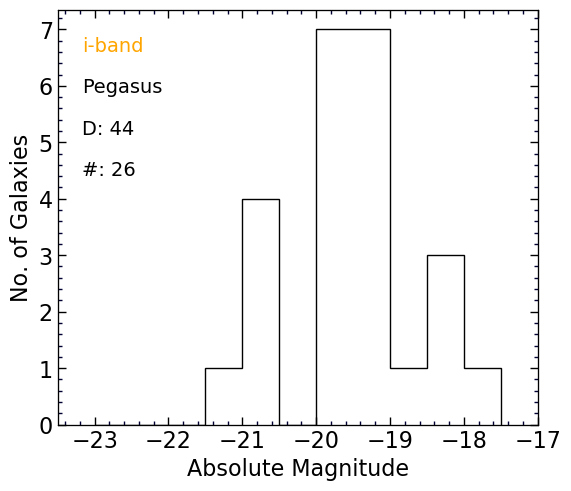

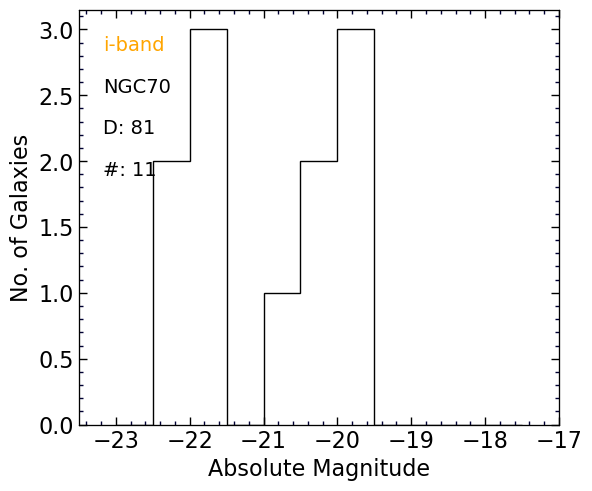

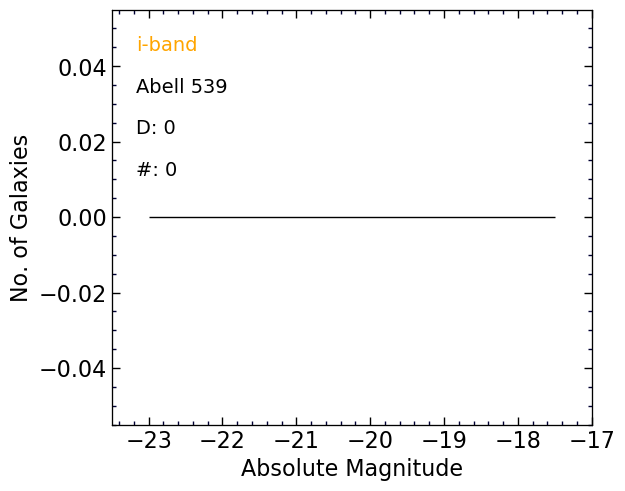

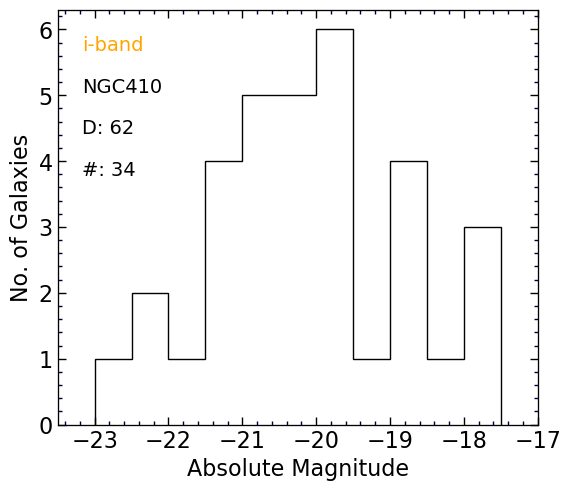

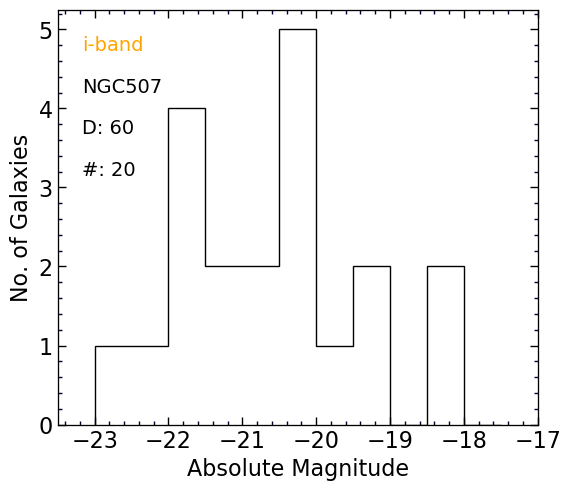

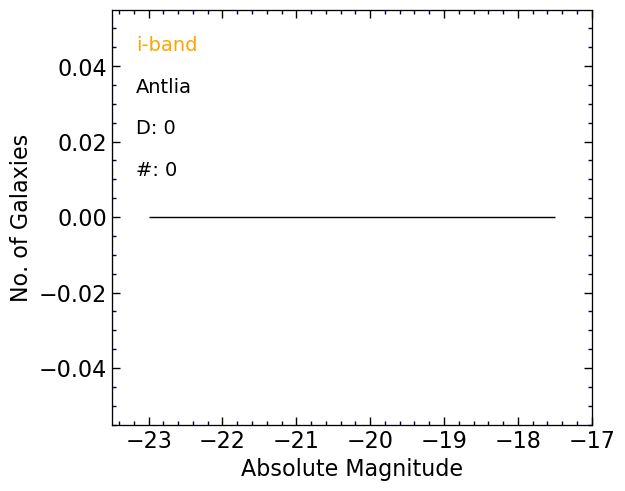

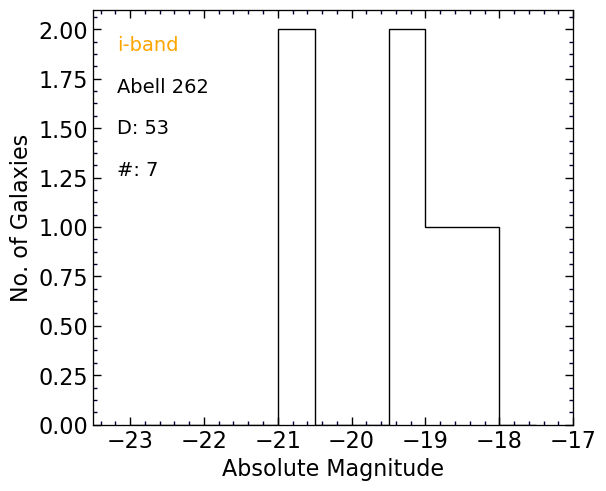

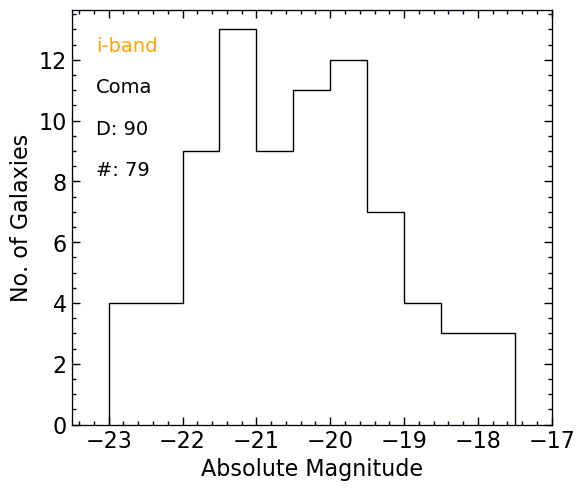

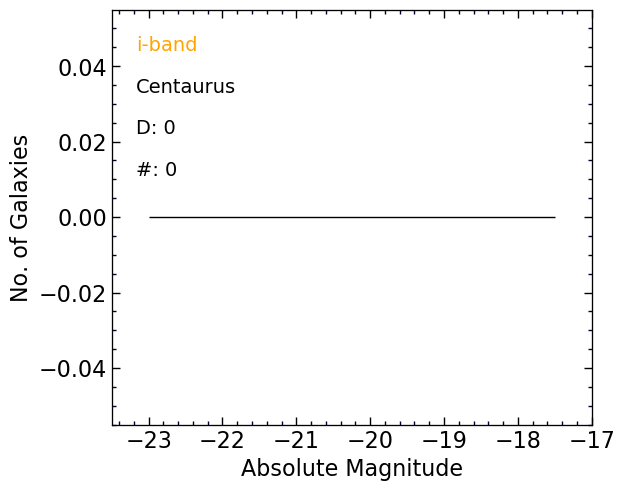

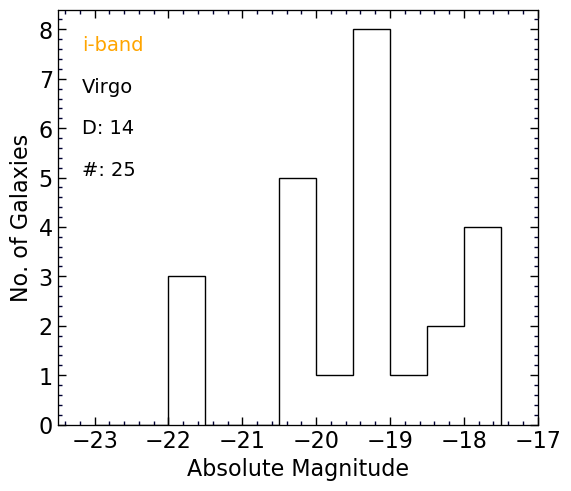

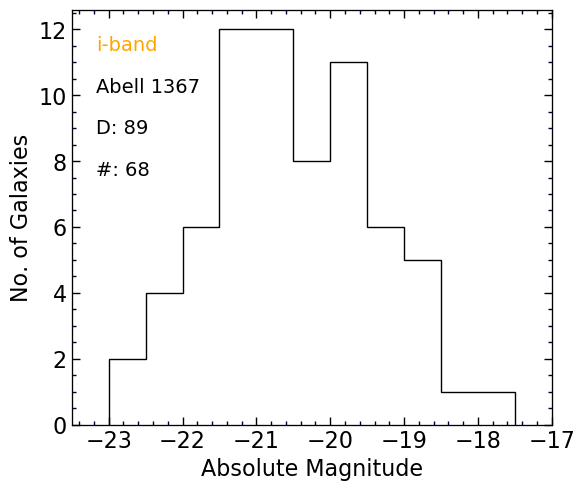

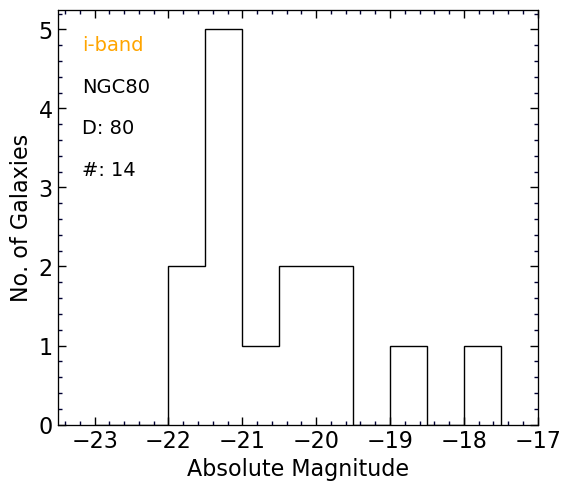

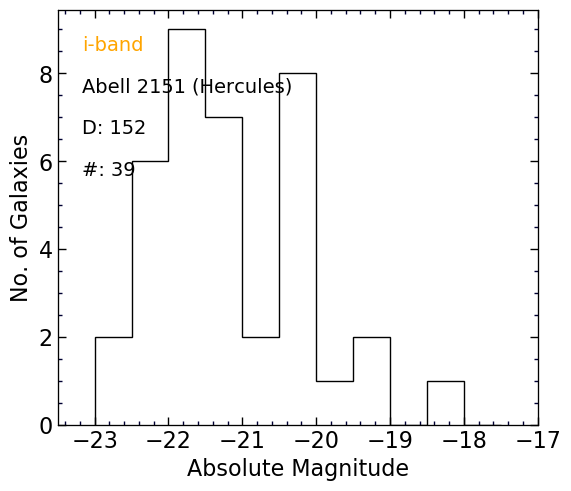

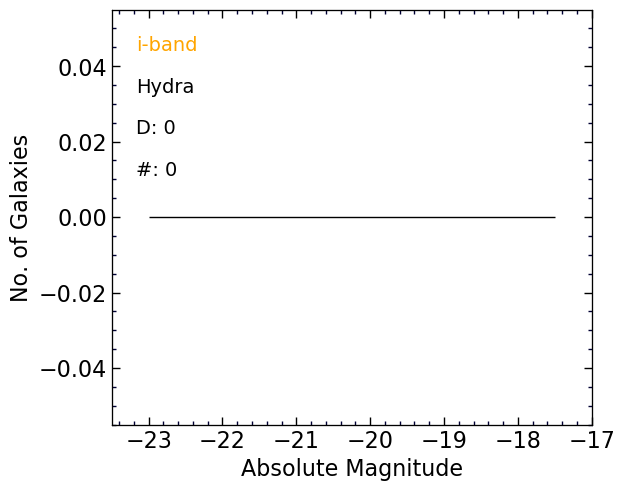

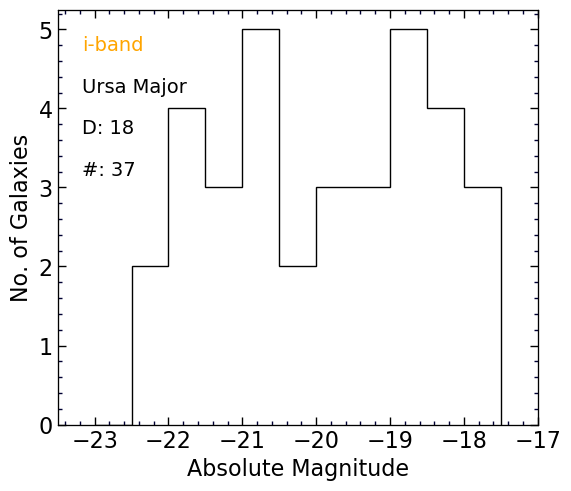

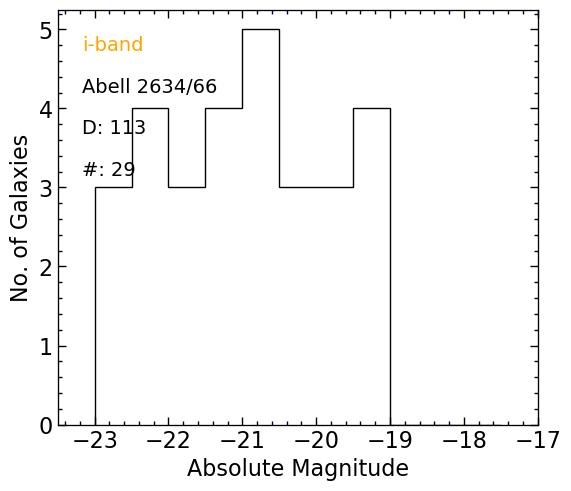

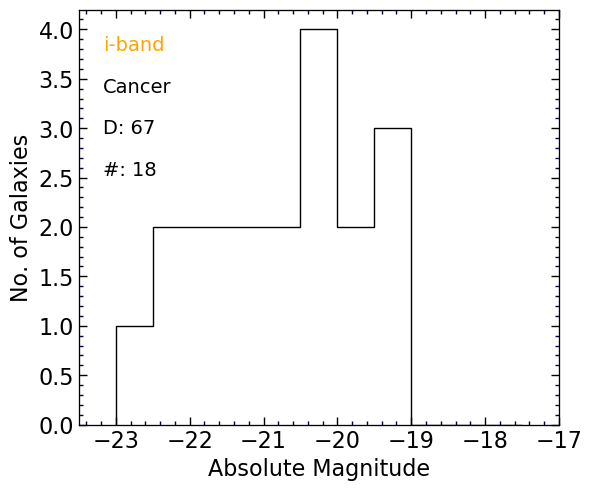

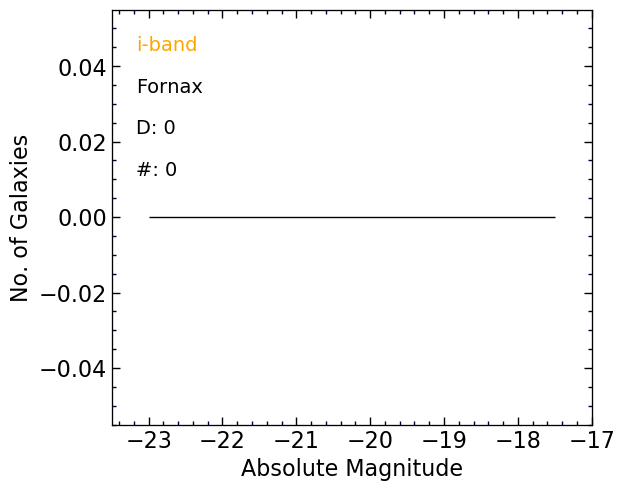

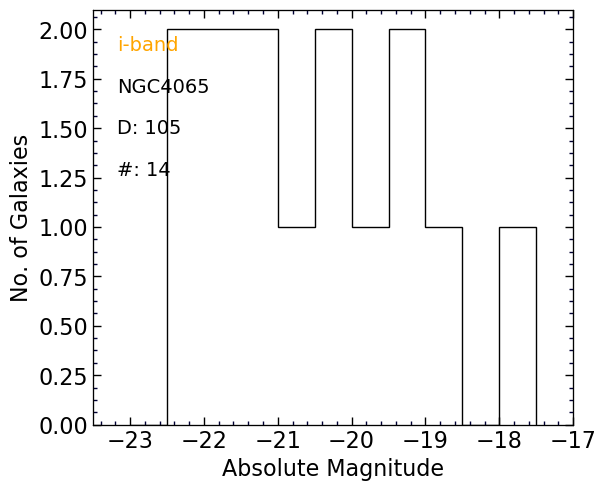

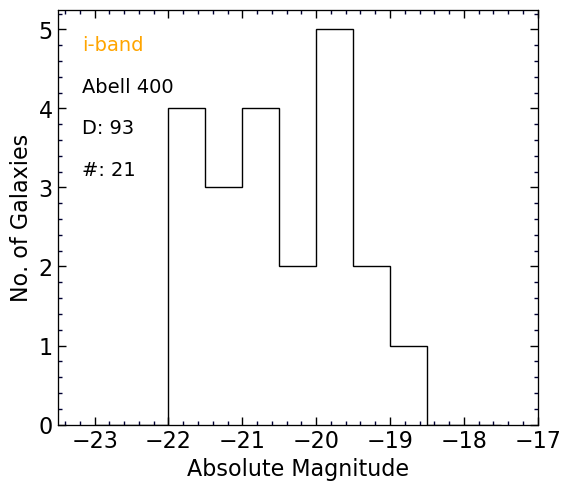

In [8]:
for key in Clusters:
    fig = py.figure(figsize=(6,5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
    ax = fig.add_subplot(111)
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

    bins = np.arange(-23,-17,0.5)

    ax.hist(MAGdict[key][0], bins=bins, histtype='step', label='whole sample', color='k')

    ax.set_xlim([-23.5,-17])

    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.95*Xlm[0]+0.05*Xlm[1]
    y0 = 0.1*Ylm[0]+0.9*Ylm[1]
    ax.text(x0,y0, band+'-band', fontsize=14, color=dye[band])
    y0 = 0.2*Ylm[0]+0.8*Ylm[1]
    ax.text(x0,y0, Clusters[key]['name'], fontsize=14, color='k')
    y0 = 0.3*Ylm[0]+0.7*Ylm[1]
    ax.text(x0,y0, 'D: '+'%d'%MAGdict[key][2], fontsize=14, color='k')
    y0 = 0.4*Ylm[0]+0.6*Ylm[1]
    ax.text(x0,y0, '#: '+'%d'%len(MAGdict[key][0]), fontsize=14, color='k')
    ax.set_xlabel('Absolute Magnitude', fontsize=16)
    ax.set_ylabel('No. of Galaxies', fontsize=16)

    set_axes(ax, Xlm, Ylm)

    fig.savefig(key+'_hist'+'_'+band+'.png')

31.11353479772139 16.699634252696292


(-23.5, -17)

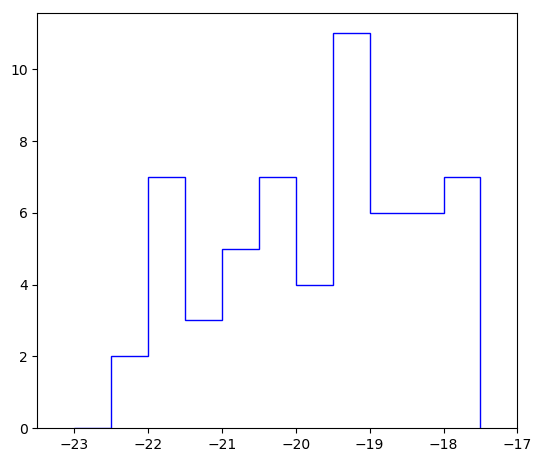

In [9]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

bins = np.arange(-23,-17,0.5)

MAGS1 = np.concatenate((MAGdict['NEST_100002'][0], MAGdict['NEST_100008'][0]))

mu1 = MAGdict['NEST_100002'][1]
mu3 = MAGdict['NEST_100008'][1]

g1 = len(MAGdict['NEST_100002'][0])
g3 = len(MAGdict['NEST_100008'][0])


mu1_av =  (g1*mu1+g3*mu3)/(g1+g3)
dist1_av = 10**((mu1_av-25.)/5.)
print mu1_av, dist1_av


ax.hist(MAGS1, bins=bins, histtype='step',  color='b')

ax.set_xlim([-23.5,-17])

33.92719117870655 61.01522761662132


(-23.5, -17)

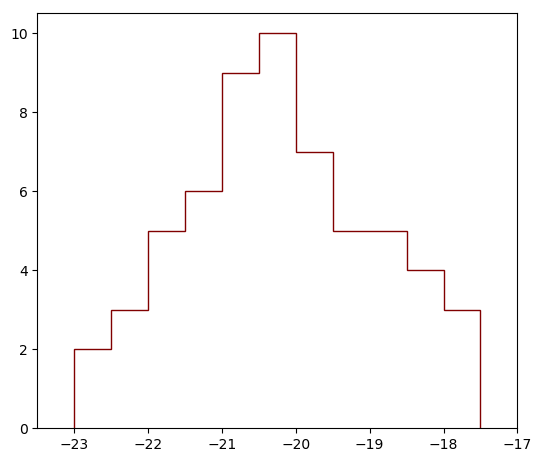

In [10]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

bins = np.arange(-23,-17,0.5)

MAGS4 = np.concatenate((MAGdict['NEST_200003'][0], MAGdict['NEST_200005'][0]))
MAGS4 = np.concatenate((MAGS4, MAGdict['NEST_200006'][0]))


mu1 = MAGdict['NEST_200003'][1]
mu2 = MAGdict['NEST_200005'][1]
mu3 = MAGdict['NEST_200006'][1]
g1 = len(MAGdict['NEST_200003'][0])
g2 = len(MAGdict['NEST_200005'][0])
g3 = len(MAGdict['NEST_200006'][0])

mu4_av =  (g1*mu1+g2*mu2+g3*mu3)/(g1+g2+g3)
dist4_av = 10**((mu4_av-25.)/5.)
print mu4_av, dist4_av


ax.hist(MAGS4, bins=bins, histtype='step',  color='maroon')



ax.set_xlim([-23.5,-17])

34.85729785114656 93.63960439316246
35.92059700441263 152.79860907691062


(-24, -17)

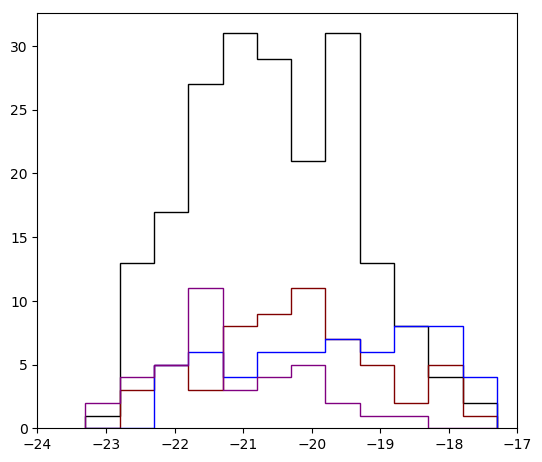

In [11]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

bins = np.arange(-23.3,-17,0.5)

MAGS = np.concatenate((MAGdict['NEST_100001'][0], MAGdict['NEST_100005'][0]))
MAGS = np.concatenate((MAGS, MAGdict['NEST_200012'][0]))
MAGS = np.concatenate((MAGS, MAGdict['NEST_200016'][0]))

mu1 = MAGdict['NEST_100001'][1]
mu2 = MAGdict['NEST_100005'][1]
mu3 = MAGdict['NEST_200012'][1]
mu5 = MAGdict['NEST_200016'][1]
g1 = len(MAGdict['NEST_100001'][0])
g2 = len(MAGdict['NEST_100005'][0])
g3 = len(MAGdict['NEST_200012'][0])
g5 = len(MAGdict['NEST_200016'][0])
mu_av =  (g1*mu1+g2*mu2+g3*mu3+g5*mu5)/(g1+g2+g3+g5)
dist_av = 10**((mu_av-25.)/5.)
print mu_av, dist_av


MAGS0 = MAGdict['NEST_100007'][0]

MAGS0 = MAGdict['NEST_100007'][0]
mu0_av =  MAGdict['NEST_100007'][1]
dist0_av = 10**((mu0_av-25.)/5.)
print mu0_av, dist0_av


n, bins, p = ax.hist(MAGS, bins=bins, histtype='step', color='k')
n4, bins, p = ax.hist(MAGS4, bins=bins, histtype='step',  color='maroon')
# n3, bins, p ax.hist(MAGS3, bins=bins, histtype='step',  color='g')
# n2, bins, p = ax.hist(MAGS2, bins=bins, histtype='step',  color='r')
n1, bins, p = ax.hist(MAGS1, bins=bins, histtype='step',  color='b')
n0, bins, p = ax.hist(MAGS0, bins=bins, histtype='step',  color='purple')

ax.set_xlim([-24,-17])

In [12]:
import copy

def histJoint(n1, n, err1, bins, MAGlim, plotME=False, ax=None):

    indx, = np.where(bins<MAGlim)
    N1 = np.sum(n1[indx])
    m1 = copy.deepcopy(n1)
    m1[indx]=0
    
    err1_l = copy.deepcopy(err1)
    
    
    err1_r = copy.deepcopy(err1)
    
    
    err1_r[indx] = 0       # set left side to zero 
    indx, = np.where(bins>=MAGlim)
    err1_l[indx[:-1]] = 0   # set right side to zero

    indx, = np.where(bins<MAGlim)
    N = np.sum(n[indx])
     
    nt = copy.deepcopy(n)
    indx, = np.where(bins>=MAGlim)
    n[indx[:-1]] = 0
    
    
    hist = n+(n1+m1)*N/N1
    err = np.sqrt(n)
    err_hist = np.sqrt(err**2+(err1_l*N/N1)**2)+2*err1_r*N/N1
    
    if plotME:
        if ax is None:
            fig = py.figure(figsize=(6,5), dpi=100)    
            fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
            ax = fig.add_subplot(111)
        
        ax.set_xlim([-24,-17])        
        #ax.bar(bins[:-1]+0.25, n1*N/N1, width = 0.5, color='green',alpha=0.1)
        ax.bar(bins[:-1]+0.25, n, width = 0.5, color='k',alpha=0.3)  
#         ax.bar(bins[:-1]+0.25, nt, width = 0.5, color='k',alpha=0.1)
        ax.step(bins[:-1]+0.5, nt)
        
        #ax.bar(bins[:-1]+0.25, hist, width = 0.5, color='k', alpha=0.5)
        #ax.errorbar(bins[:-1]+0.25,hist,yerr=err_hist, fmt='ko')
        return ax, hist, err_hist, np.sum(n)
        
    return hist, err_hist
    



In [13]:
bins = np.arange(-24,-17,0.4)
print bins
n, bins, p = ax.hist(MAGS, bins=bins, histtype='step', color='k')
n4, bins, p = ax.hist(MAGS4, bins=bins, histtype='step',  color='maroon')
n1, bins, p = ax.hist(MAGS1, bins=bins, histtype='step',  color='b')
n0, bins, p = ax.hist(MAGS0, bins=bins, histtype='step',  color='purple')


bins_ = np.arange(-23.8,-17,0.4)
print bins_
n_, bins_, p = ax.hist(MAGS, bins=bins_, histtype='step', color='k')
n4_, bins_, p = ax.hist(MAGS4, bins=bins_, histtype='step',  color='maroon')
n1_, bins_, p = ax.hist(MAGS1, bins=bins_, histtype='step',  color='b')
n0_, bins_, p = ax.hist(MAGS0, bins=bins_, histtype='step',  color='purple')


bins_p = np.arange(-23.9,-17,0.4)
print bins_p
n_p, bins_p, p = ax.hist(MAGS, bins=bins_p, histtype='step', color='k')
n4_p, bins_p, p = ax.hist(MAGS4, bins=bins_p, histtype='step',  color='maroon')
n1_p, bins_p, p = ax.hist(MAGS1, bins=bins_p, histtype='step',  color='b')
n0_p, bins_p, p = ax.hist(MAGS0, bins=bins_p, histtype='step',  color='purple')

[-24.  -23.6 -23.2 -22.8 -22.4 -22.  -21.6 -21.2 -20.8 -20.4 -20.  -19.6
 -19.2 -18.8 -18.4 -18.  -17.6 -17.2]
[-23.8 -23.4 -23.  -22.6 -22.2 -21.8 -21.4 -21.  -20.6 -20.2 -19.8 -19.4
 -19.  -18.6 -18.2 -17.8 -17.4]
[-23.9 -23.5 -23.1 -22.7 -22.3 -21.9 -21.5 -21.1 -20.7 -20.3 -19.9 -19.5
 -19.1 -18.7 -18.3 -17.9 -17.5 -17.1]


[-23.9 -23.5 -23.1 -22.7 -22.3 -21.9 -21.5 -21.1 -20.7 -20.3 -19.9 -19.5
 -19.1 -18.7 -18.3 -17.9 -17.5 -17.1]
[-24.  -23.6 -23.2 -22.8 -22.4 -22.  -21.6 -21.2 -20.8 -20.4 -20.  -19.6
 -19.2 -18.8 -18.4 -18.  -17.6 -17.2]
[-23.8 -23.4 -23.  -22.6 -22.2 -21.8 -21.4 -21.  -20.6 -20.2 -19.8 -19.4
 -19.  -18.6 -18.2 -17.8 -17.4]
-22.037913414217165 -1
0.076175656500722


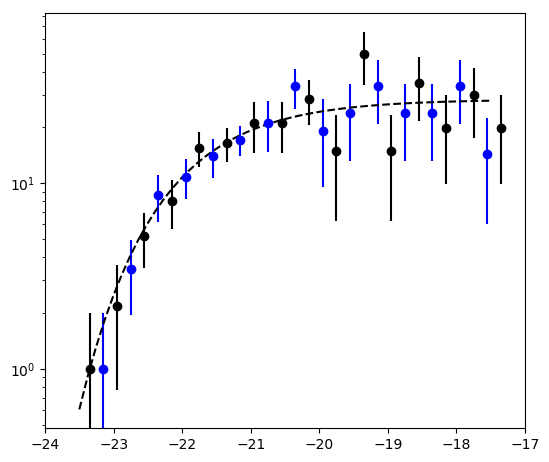

In [14]:
def LFfunction(M, fs, u):
    
    alpha = -1
    ms = -20+u
    dm = 0.4*(ms-M)
    c = 10.**dm
    b = fs*(c**(alpha+1)) 
    
    return b/np.exp(c)



fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-24,-17])
ax.set_yscale("log", nonposy='clip')


myHist0, err_hist0 = histJoint(n1, n4, np.sqrt(n1), bins, MAGlim=-20.4)
myHist1, err_hist1 = histJoint(myHist0, n, err_hist0, bins, MAGlim=-21.6)
myHist2, err_hist2 = histJoint(myHist1, n0, err_hist1, bins, MAGlim=-22)
ax.errorbar(bins[:-1]+0.25,myHist2,yerr=err_hist2, fmt='ko')

myHist0_, err_hist0_ = histJoint(n1_, n4_, np.sqrt(n1_), bins_, MAGlim=-20.6)
myHist1_, err_hist1_ = histJoint(myHist0_, n_, err_hist0_, bins_, MAGlim=-21.4)
myHist2_, err_hist2_ = histJoint(myHist1_, n0_, err_hist1_, bins_, MAGlim=-22.2)
ax.errorbar(bins_[:-1]+0.25,myHist2_,yerr=err_hist2_, fmt='bo')


myHist0_p, err_hist0_p = histJoint(n1_p, n4_p, np.sqrt(n1_p), bins_p, MAGlim=-20.3)
myHist1_p, err_hist1_p = histJoint(myHist0_p, n_p, err_hist0_p, bins_p, MAGlim=-21.5)
myHist2_p, err_hist2_p = histJoint(myHist1_p, n0_p, err_hist1_p, bins_p, MAGlim=-22.3)
# ax.errorbar(bins_p[:-1]+0.25,myHist2_p,yerr=err_hist2_p, fmt='go')

print bins_p
print bins
print bins_


xt = np.concatenate((bins[:-1]+0.2, bins_[:-1]+0.2))
# xt = np.concatenate((xt, bins_p[:-1]+0.2))


yt = np.concatenate((myHist2,myHist2_))
# yt = np.concatenate((yt,myHist2_p))

err = np.concatenate((err_hist2,err_hist2_))
# err = np.concatenate((err,err_hist2_p))

indx, = np.where(xt>-23.5)
indx_, = np.where(xt[indx]<-18)
x = xt[indx[indx_]]
y = yt[indx[indx_]]




fit, cov = curve_fit(LFfunction, x, y, sigma=err[indx[indx_]]) 
M = np.linspace(-23.5,-17.5,50)
fs = fit[0]; u = fit[1]; alpha = -1
N = LFfunction(M, fs, u)
ax.plot(M,N,'k--')

print u-20., alpha
print np.sqrt(cov[1][1])
u0=u

[-24.  -23.5 -23.  -22.5 -22.  -21.5 -21.  -20.5 -20.  -19.5 -19.  -18.5
 -18.  -17.5 -17. ]


UnboundLocalError: local variable 'x_ax' referenced before assignment

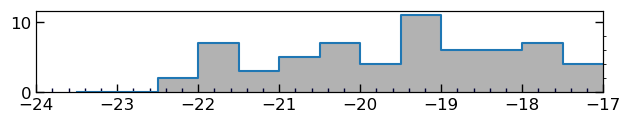

In [15]:
bins = np.arange(-24,-16.5,0.5)
print bins
n, bins, p = ax.hist(MAGS, bins=bins, histtype='step', color='k')
n4, bins, p = ax.hist(MAGS4, bins=bins, histtype='step',  color='maroon')
n1, bins, p = ax.hist(MAGS1, bins=bins, histtype='step',  color='b')
n0, bins, p = ax.hist(MAGS0, bins=bins, histtype='step',  color='purple')


fig = py.figure(figsize=(7, 6), dpi=100) 
fig.subplots_adjust(wspace=0, top=0.98, bottom=0.04, left=0.17, right=0.98)

gs = gridspec.GridSpec(5, 1, height_ratios=[2,1,1,1,1]) 


ax = plt.subplot(gs[1])
ax.step(bins[:-1]+0.5, n1)
ax.bar(bins[:-1]+0.25, n1, width = 0.5, color='k',alpha=0.3) 
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
plt.setp(ax.get_xticklabels(), visible=False) 
set_label(ax, 2, 75, 'Virgo - Ursa Major', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu1_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist1_av, fontsize=10)
Ngray = np.sum(n1)
set_label(ax, 80, 70, 'n = %.d'%Ngray, fontsize=10)

ax = plt.subplot(gs[2])
ax, myHist0, err_hist0, Ngray = histJoint(n1, n4, np.sqrt(n1), bins, MAGlim=-20.5, plotME=True, ax=ax)
# ax.set_yticks([5,10])
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
plt.setp(ax.get_xticklabels(), visible=False)   
ax.set_ylabel('Number', fontsize=14, labelpad=7)
set_label(ax, 2, 75, 'A262 - N410 - N507', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu4_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist4_av, fontsize=10)
set_label(ax, 80, 70, 'n = %.d'%Ngray, fontsize=10)

ax = plt.subplot(gs[3])
ax, myHist1, err_hist1, Ngray = histJoint(myHist0, n, err_hist0, bins, MAGlim=-21.5, plotME=True, ax=ax)
# ax.set_yticks([20])
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
plt.setp(ax.get_xticklabels(), visible=False) 
set_label(ax, 2, 75, 'Coma - A400 - A2634/66', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist_av, fontsize=10)
set_label(ax, 80, 70, 'n = %.d'%Ngray, fontsize=10)

ax = plt.subplot(gs[4])
ax, myHist2, err_hist2, Ngray = histJoint(myHist1, n0, err_hist1, bins, MAGlim=-22, plotME=True, ax=ax)
# ax.set_yticks([5])
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
ax.set_xlabel(r'$M_{i}$'+' [mag]', fontsize=14, labelpad=7)
set_label(ax, 2, 75, 'A2151 (Hercules)', fontsize=10)
set_label(ax, 2, 55, r'$\mu_d$'+' = %.0f'%mu0_av, fontsize=10)
set_label(ax, 2, 30, 'd = %.0f'%dist0_av, fontsize=10)
set_label(ax, 80, 70, 'n = %.d'%Ngray, fontsize=10)

ax = plt.subplot(gs[0])
ax.bar(bins[:-1]+0.25, myHist2, width = 0.5, color='orange',alpha=0.3) 
ax.step(bins[:-1]+0.5, myHist2, color='k')
ax.errorbar(bins[:-1]+0.25,myHist2,yerr=err_hist2, fmt='ko')
# ax.set_yticks(np.arange(10,60,10))
set_axes(ax, [-24,-17], minor=False, fontsize=12, twinx=False, inout='in')
plt.setp(ax.get_xticklabels(), visible=False)
set_label(ax, 3, 85, 'Total')

plt.subplots_adjust(hspace=.2, wspace=0)

In [ ]:
def LFfunction(M, fs, u,alpha):
    
    ms = -20+u
    dm = 0.4*(ms-M)
    c = 10.**dm
    b = fs*(c**(alpha+1)) 
    
    return b/np.exp(c)

def LFfunction1(M, fs, u):
    
    alpha = -1.00
    ms = -20+u
    dm = 0.4*(ms-M)
    c = 10.**dm
    b = fs*(c**(alpha+1)) 
    
    return b/np.exp(c)


xt = bins[:-1]+0.25
yt = myHist2


print xt
print yt


fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax_x, ax_y = set_axes(ax, [-24,-17], [2,100])
ax_y.set_yscale("log", nonposy='clip')


indx = [1,2,3,4,5,6,7,9,10,11,12]
x = xt[indx]
y = yt[indx]
ax.errorbar(x,y,yerr=err_hist2[indx], fmt='ko')
M = np.linspace(-23,-17.5,50)
fit, cov = curve_fit(LFfunction, x, y, sigma=err_hist2[indx]) 
fs = fit[0]; u = fit[1]; alpha = fit[2]
N = LFfunction(M, fs, u, alpha)
ax.plot(M,N,'k--')
print u-20., alpha
print np.sqrt(cov[1][1]), np.sqrt(cov[2][2])
set_label(ax, 5, 65, r'$M^*_{i}$'+' = %.1f'%(u-20)+r'$\pm$'+'%.1f'%np.sqrt(cov[1][1]), fontsize=14, color='k')
set_label(ax, 5, 50, r'$\alpha$'+' = %.1f'%alpha+r'$\pm$'+'%.1f'%np.sqrt(cov[2][2]), fontsize=14, color='k')

indx = [1,2,3,4,5,6,7,9,10,11,12]
x = xt[indx]
y = yt[indx]
M = np.linspace(-23,-17.5,50)
fit, cov = curve_fit(LFfunction1, x, y, sigma=err_hist2[indx]) 
fs = fit[0]; u = fit[1]; alpha = -1
N = LFfunction1(M, fs, u)
ax.plot(M,N,'b--')
print u-20., alpha
print np.sqrt(cov[1][1])
set_label(ax, 60, 2, r'$M^*_{i}$'+' = %.1f'%(u-20)+r'$\pm$'+'%.1f'%np.sqrt(cov[1][1]), fontsize=14, color='b')
set_label(ax, 60, 1, r'$\alpha$'+' = %.1f'%alpha, fontsize=14, color='b')


indx = [0,8,13]
ax.errorbar(xt[indx],yt[indx],yerr=err_hist2[indx], fmt='ko', mfc='white')

ax.set_yscale("log", nonposy='clip')



ax.set_xlabel(r'$M_{i}$'+' [mag]', fontsize=16)
ax.set_ylabel('Number', fontsize=16)
